# Xarray を用いた解析事例

Pythonを用いた気候データの解析を行う際、データファイルのフォーマットが"[netcdf](https://unidata.ucar.edu/software/netcdf/)"形式である場合に用いられることが多い"[xarray](https://github.com/pydata/xarray)"ライブラリの使い方を紹介する。

気象庁は [NEAR-GOOS地域リアルタイムデータベース](https://www.data.jma.go.jp/gmd/goos/data/database.html) から海面水温データ(MGDSST/HIMSST/COBE-SST2)やデータ同化して作成した海水温や海流のデータを公開している。

ここでは気象庁が公開しているCOBE-SST2データ（テキストファイル形式）をnetcdf形式に変換したファイルを使用する。

## COBE-SST2データを読み込む

最初にライブラリ群を読み込む。

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

COBE-SST2のデータを``xarray.open_dataset()``を用いて読み込む。

In [2]:
ds = xr.open_dataset("./Data/cobe2_sst.1900-2020.nc")

``xarray.open_dataset()``は、Datasetとして扱うのに必要な情報を"ds"に読み込む。
そしてこの時点でデータはメモリにロードされていない。

データの情報を表示させる。

In [3]:
ds

<xarray.Dataset> Size: 376MB
Dimensions:  (time: 1452, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    sst      (time, lat, lon) float32 376MB ...
Attributes:
    CDI:             Climate Data Interface version 2.3.0 (https://mpimet.mpg...
    Conventions:     CF-1.6
    title:           JMA COBE2 SST
    URL:             https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product...
    Convensions:     CF-1.4
    ConversionDate:  2023-09-22 16:23:45
    history:         Mon Nov 25 15:41:10 2024: cdo -f nc4c -z zip_9 copy -sel...
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...
    CDO:             Climate Data Operators version 2.3.0 (https://mpimet.mpg...

dsは「次元(dimensions)」、「座標(coordinates)」、「変数(data variables)」、「インデックス(indexes)」、「属性(attributes)」から構成されている。なお、この時点ではデータ自体はメモリに読み込まれていない。

このデータでは、時間軸で2076個、経度軸で360個、緯度軸で180個の格子点が存在する。
また、座標は時間(time)は"datetime64"型であり、緯度(lat)と経度(lon)は倍精度実数型である。

COBE-SST2では緯度が「北極点から始まり、南極点で終わる」向きに座標が定義されていることに注意が必要である。


東経150度、北緯50度に最も近い格子点のデータを``.sel()``を用いて読み込む。

In [4]:
ds["sst"].sel(lon=150, lat=50, method="nearest")

<xarray.DataArray 'sst' (time: 1452)> Size: 6kB
[1452 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
    lon      float64 8B 150.5
    lat      float64 8B 50.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

ここで" ds["sst"] "としてDataSetの変数"sst"にアクセスしているが、" ds.sst "という書き方でも変数"sst"にアクセスできる。

In [5]:
ds.sst.sel(lon=150, lat=50, method="nearest")

<xarray.DataArray 'sst' (time: 1452)> Size: 6kB
[1452 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
    lon      float64 8B 150.5
    lat      float64 8B 50.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

sstに実際にデータを読み込む。

In [6]:
sst = ds["sst"].sel(lon=150, lat=50, method="nearest")
sst

<xarray.DataArray 'sst' (time: 1452)> Size: 6kB
[1452 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
    lon      float64 8B 150.5
    lat      float64 8B 50.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

2001年から2010年の間のsstの時間変化をxarrayの機能を用いてプロットする。
``sel()``に"time=slice()"として与えることで特定期間のデータを切り出せる。

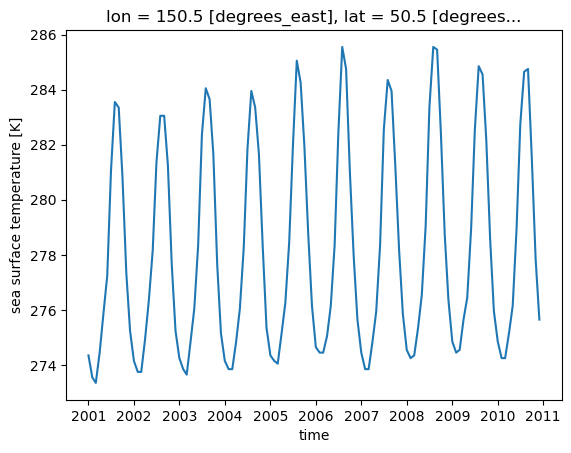

In [7]:
sst.sel(time=slice("2001-01-01","2010-12-01")).plot()

## 気候値と偏差の作成

xarrayの``groupby()``機能を用いて気候値を作成する。
ここではdsの"time"の情報から月("dt.month")をキーとする。

In [8]:
ds.sst.groupby(ds.time.dt.month)

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12/12 groups present with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

次の様に記述しても同じである。

In [9]:
ds.sst.groupby("time.month")

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12/12 groups present with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

各月のsstの気候値を作成する。

In [10]:
sst_clim = (ds.sst
            .sel(time=slice("1991-01-01","2020-12-31"))
            .groupby("time.month")
            .mean())
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 180, lon: 360)> Size: 3MB
array([[[271.4534 , 271.4534 , 271.4534 , ..., 271.4534 , 271.4534 ,
         271.4534 ],
        [271.45007, 271.45007, 271.45007, ..., 271.45007, 271.45007,
         271.45007],
        [271.45007, 271.45007, 271.45007, ..., 271.45007, 271.45007,
         271.45007],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.4534 , 271.4534 , 271.4534 , ..., 271.45007, 271.45007,
         271.45007],
        [271.45007, 271.45007, 271.45007, ..., 271.45007, 271.45007,
         271.45007],
        [271.45007, 271.45007, 271.45007, ..., 271.45007, 271.45007,
         271.45007],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.47   , 271.47   , 271.46667, ..., 271.47   , 271.47   ,
         271.47   ],
        [271.46667, 271.46667, 271.46667, ..., 271.47   , 271.47   ,
         271.47   ],
        [271.46335, 271.46335, 271.46005, ..., 271.47333, 271.46667,
         271.46335],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

東経150度、北緯50度に最も近い格子点の気候値の季節変化をプロットする。

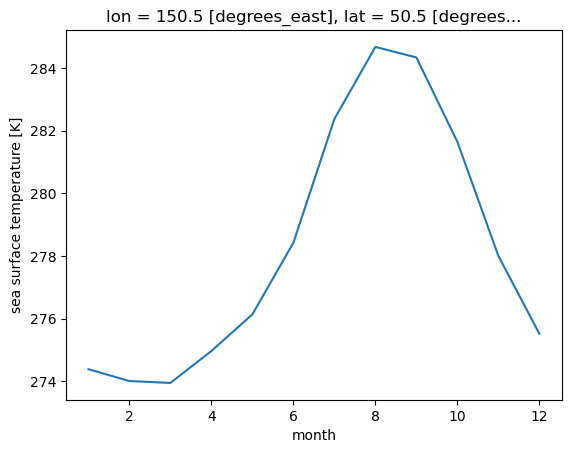

In [11]:
sst_clim.sel(lon=150, lat=50, method="nearest").plot()

東経150度から160度の間のSSTの平均値を作成し、赤道から北緯60度の間の季節変化をプロットする。
なお**緯度は北極から南向きに定義されている**ので、"slice(0,60)"ではなく
**"<font color="red">slice(60,0)</font>"**
とする。

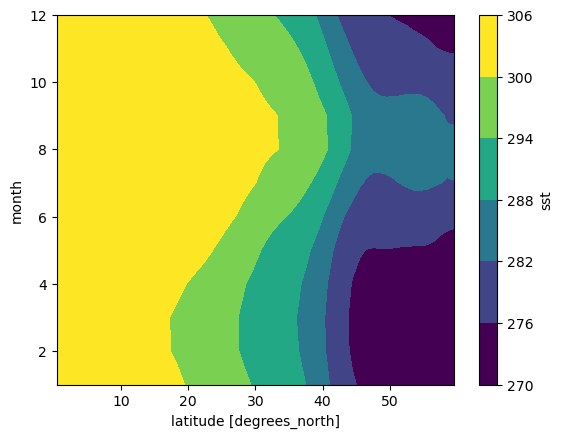

In [12]:
sst_clim2 = sst_clim.sel(lon=slice(150,160)).mean("lon")
sst_clim3 = sst_clim2.sel(lat=slice(60,0))
sst_clim3.plot.contourf()

x軸を月、y軸を緯度にするために"transpose()"を用いる。"transpose()"の代わりに"T"としてもよい。

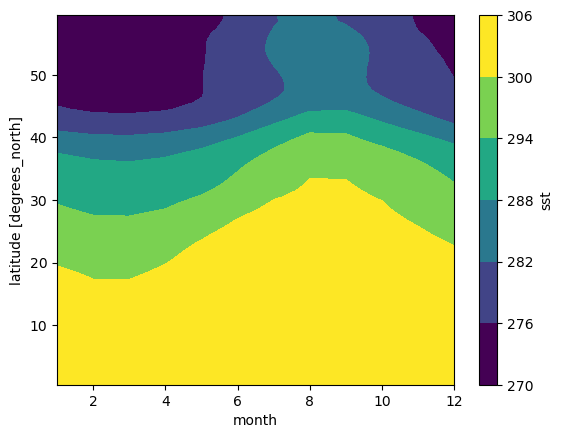

In [13]:
sst_clim3.transpose().plot.contourf()

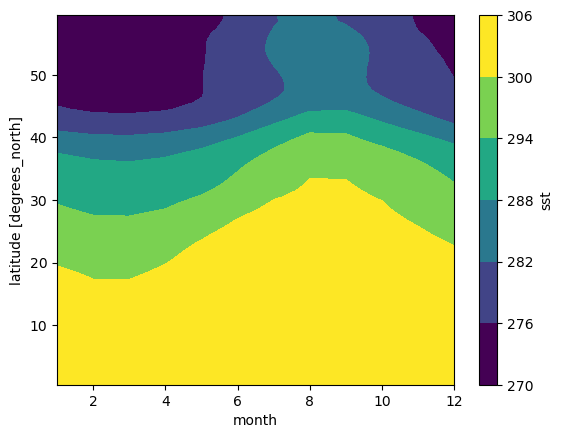

In [14]:
sst_clim3.T.plot.contourf()

1月と7月のSSTの差の空間分布を描く。

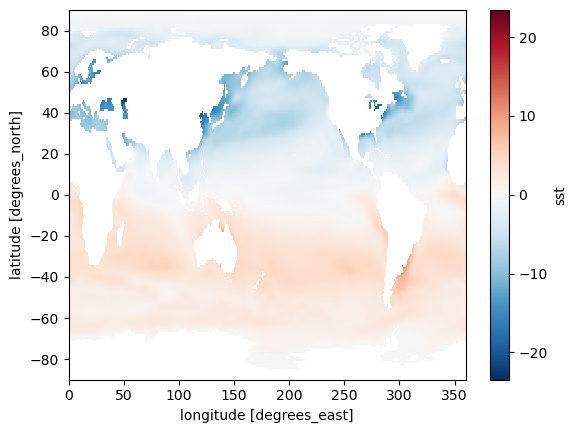

In [15]:
(sst_clim.sel(month=1) - sst_clim.sel(month=7)).plot()

sstの偏差"anomaly"を作成する。

In [16]:
sst_anom = ds.sst.groupby("time.month") - sst_clim

東経150度、北緯50度に最も近い格子点でのSST偏差の時系列を描く。

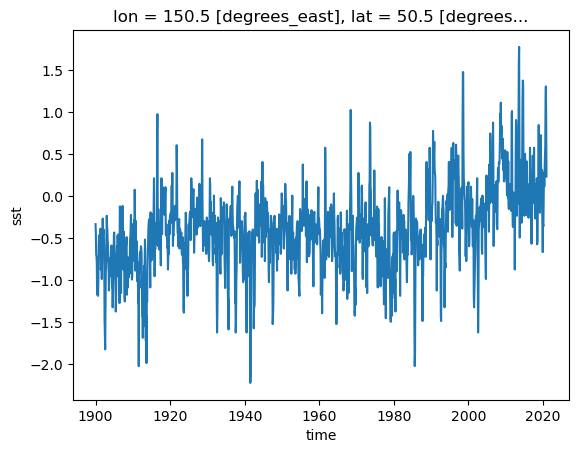

In [17]:
sst_anom.sel(lon=150, lat=50, method="nearest").plot()

xarrayの``resample()``を用いて、SST偏差の年平均値を作成する。
ここで"YS"と書いているのは"Year Start"の意味である。

In [18]:
sst_anom_yr = (sst_anom.sel(lon=150, lat=50, method="nearest")
               .resample(time="YS")
               .mean())

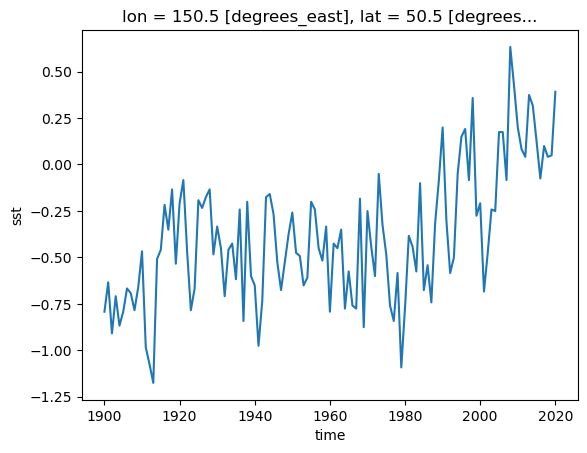

In [19]:
sst_anom_yr.plot()

さらにSST偏差の年平均値に対して、``rolling()``を用いて11年移動平均を適用する。

In [20]:
sst_anom_yr_smth = (sst_anom_yr
                    .rolling(time=11, center=True)
                    .mean())

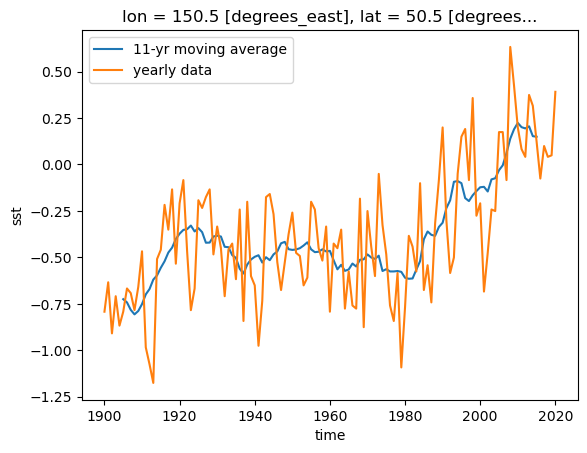

In [21]:
sst_anom_yr_smth.plot()
sst_anom_yr.plot()
plt.legend(["11-yr moving average","yearly data"])

7月の気候値でSSTが摂氏28度以上の領域だけを作図する。

In [22]:
sst_clim_jul = sst_clim.sel(month=7) - 273.15
sst_clim_jul_warm = sst_clim_jul.where(sst_clim_jul > 28.0)

**matplotlibで作図する際、作図に関するコードはひとつのセルの中に全て書く必要がある。**

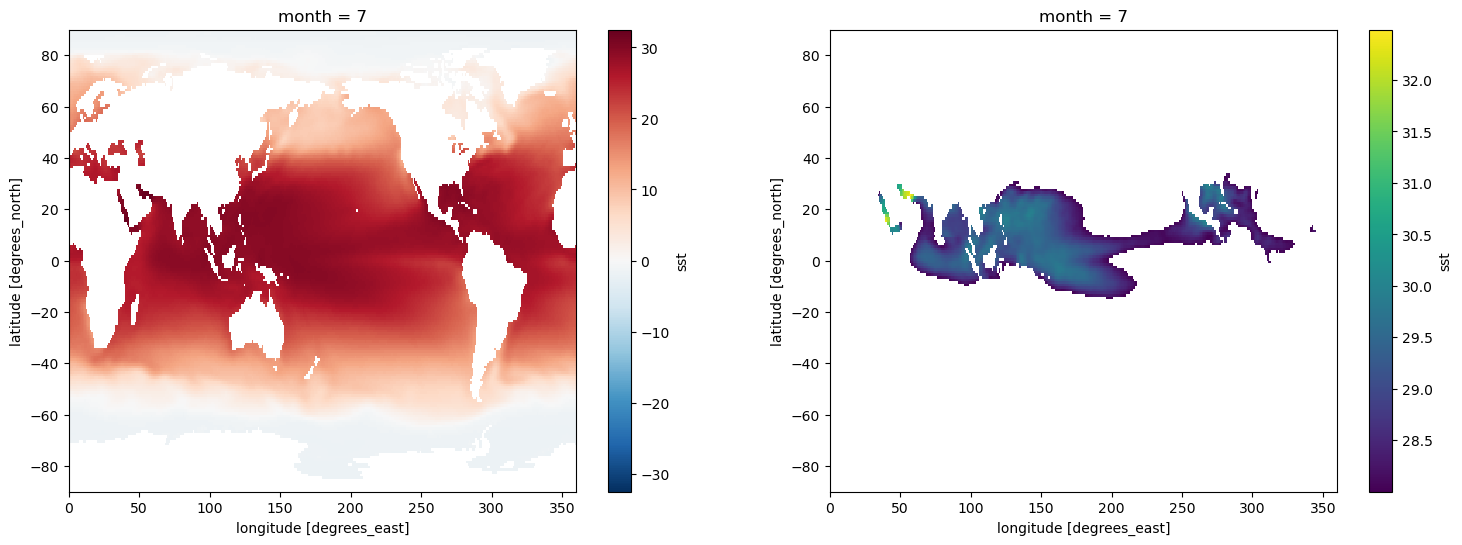

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(18,6))
sst_clim_jul.plot(ax=axes[0])
sst_clim_jul_warm.plot(ax=axes[1])

各月の気候値をプロットする。

Text(0.5, 0.98, 'COBE SST2 Climatology')

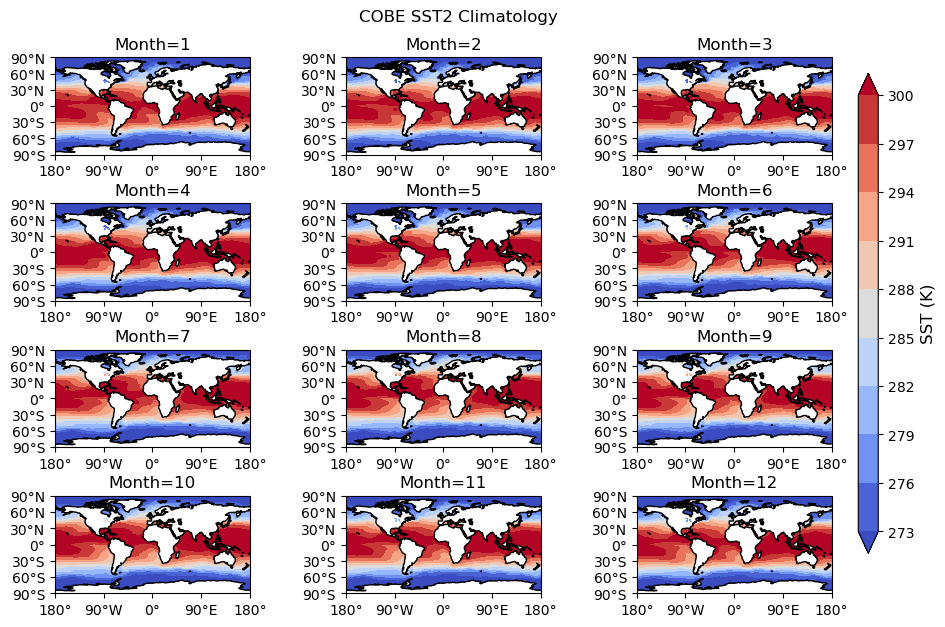

In [24]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

clevs = np.arange(273,303,3)

fig, axs = plt.subplots(nrows=4, ncols=3,
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        figsize=(10,8))
axs = axs.flatten()

for im in range(0,12):
    data = sst_clim.isel(month=im)
    data, lons = add_cyclic_point(data, coord=ds["lon"])

    cs = axs[im].contourf(lons, ds["lat"], data
                          , clevs
                          , transform = ccrs.PlateCarree()
                          , cmap="coolwarm"
                          , extend="both")
    jm = im + 1
    axs[im].set_title(f"Month={jm}")
    axs[im].coastlines()

    axs[im].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[im].xaxis.set_major_formatter(lon_formatter)

    axs[im].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[im].yaxis.set_major_formatter(lat_formatter)

fig.subplots_adjust(bottom=0.25, top=0.92, left=0.05, right=0.92,
                   wspace=0.01, hspace=0.5)

cbar_ax = fig.add_axes([0.9, 0.3, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label("SST (K)", fontsize=12)

plt.suptitle("COBE SST2 Climatology")

## 重み付き平均値

北太平洋域のSSTの季節平均値を作成する。
季節ごとの日数を考慮した重み付き平均値と、日数の違いを考慮しない単純な３か月平均の違いをみることが目的である。

In [25]:
ds2 = ds.sel(lat=slice(70,0), lon=slice(110,270))
ds2

<xarray.Dataset> Size: 65MB
Dimensions:  (time: 1452, lon: 160, lat: 70)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
  * lon      (lon) float64 1kB 110.5 111.5 112.5 113.5 ... 267.5 268.5 269.5
  * lat      (lat) float64 560B 69.5 68.5 67.5 66.5 65.5 ... 4.5 3.5 2.5 1.5 0.5
Data variables:
    sst      (time, lat, lon) float32 65MB ...
Attributes:
    CDI:             Climate Data Interface version 2.3.0 (https://mpimet.mpg...
    Conventions:     CF-1.6
    title:           JMA COBE2 SST
    URL:             https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product...
    Convensions:     CF-1.4
    ConversionDate:  2023-09-22 16:23:45
    history:         Mon Nov 25 15:41:10 2024: cdo -f nc4c -z zip_9 copy -sel...
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...
    CDO:             Climate Data Operators version 2.3.0 (https://mpimet.mpg...

SSTデータの単位を「摂氏」にする。

In [26]:
ds2["sst_c"] = ds2["sst"] - 273.15
ds2["sst_c"] = ds2["sst_c"].assign_attrs({'units': 'degC'})
ds2["sst_c"]

<xarray.DataArray 'sst_c' (time: 1452, lat: 70, lon: 160)> Size: 65MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan, -1.6999817],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [27.300018 , 27.300018 ,        nan, ..., 26.800018 ,
         26.899994 , 27.       ],
        [       nan,        nan,        nan, ..., 26.399994 ,
         26.399994 , 26.600006 ],
        [       nan,        nan,        nan, ..., 25.800018 ,
         25.800018 , 25.899994 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan, -1.7999878],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [29.200012 , 29.100006 ,        nan, ..., 25.899994 ,
         26.       , 26.       ],
        [       nan,        nan,        nan, ..., 24.800018 ,
         24.899994 , 25.       ],
        [       nan,        nan,        nan, ..., 23.399994 ,
         23.5      , 23.700012 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan, -1.6000061],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [28.800018 , 28.800018 ,        nan, ..., 25.800018 ,
         26.       , 26.       ],
        [       nan,        nan,        nan, ..., 24.899994 ,
         25.100006 , 25.200012 ],
        [       nan,        nan,        nan, ..., 23.800018 ,
         23.899994 , 24.100006 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
  * lon      (lon) float64 1kB 110.5 111.5 112.5 113.5 ... 267.5 268.5 269.5
  * lat      (lat) float64 560B 69.5 68.5 67.5 66.5 65.5 ... 4.5 3.5 2.5 1.5 0.5
Attributes:
    units:    degC

各月の日数はxarrayの"dtアクセサ"を用いて得られる。

In [27]:
month_length = ds2["time"].dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 1452)> Size: 12kB
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

季節ごとの日数から重みを決めて、重み付き季節平均値を作成する。

In [28]:
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)
sst_c_weighted = (ds2["sst_c"] * weights).groupby("time.season").sum(dim="time")
sst_c_weighted

<xarray.DataArray (season: 4, lat: 70, lon: 160)> Size: 358kB
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -1.72226483],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [27.57349544, 27.59937386,  0.        , ..., 26.51790881,
         26.61772501, 26.71925447],
        [ 0.        ,  0.        ,  0.        , ..., 25.84653504,
         25.92452918, 26.03147962],
        [ 0.        ,  0.        ,  0.        , ..., 25.03631624,
         25.08666351, 25.17293666]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.67684668],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [28.74975505, 28.68985545,  0.        , ..., 27.68165368,
         27.70198211, 27.70970739],
        [ 0.        ,  0.        ,  0.        , ..., 26.88029734,
         26.81948182, 26.75813669],
        [ 0.        ,  0.        ,  0.        , ..., 26.09909833,
         25.98351278, 25.86575296]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.78108449],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [28.63464495, 28.54575998,  0.        , ..., 25.7959826 ,
         25.85002901, 25.90249508],
        [ 0.        ,  0.        ,  0.        , ..., 24.70115069,
         24.78297733, 24.90395635],
        [ 0.        ,  0.        ,  0.        , ..., 23.29157875,
         23.38687405, 23.55445165]]])
Coordinates:
  * lon      (lon) float64 1kB 110.5 111.5 112.5 113.5 ... 267.5 268.5 269.5
  * lat      (lat) float64 560B 69.5 68.5 67.5 66.5 65.5 ... 4.5 3.5 2.5 1.5 0.5
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

他方、季節ごとの日数を気にせずに季節平均値を作成する。

In [29]:
sst_c_unweighted = ds2["sst_c"].groupby("time.season").mean("time")

重み付き季節平均値と単純季節平均値の差を取る。

In [30]:
sst_c_diff = sst_c_weighted - sst_c_unweighted

重み付き季節平均値、単純季節平均値、両者の差の空間分布を描く。

Text(0.5, 0.98, 'Seasonal Mean SST')

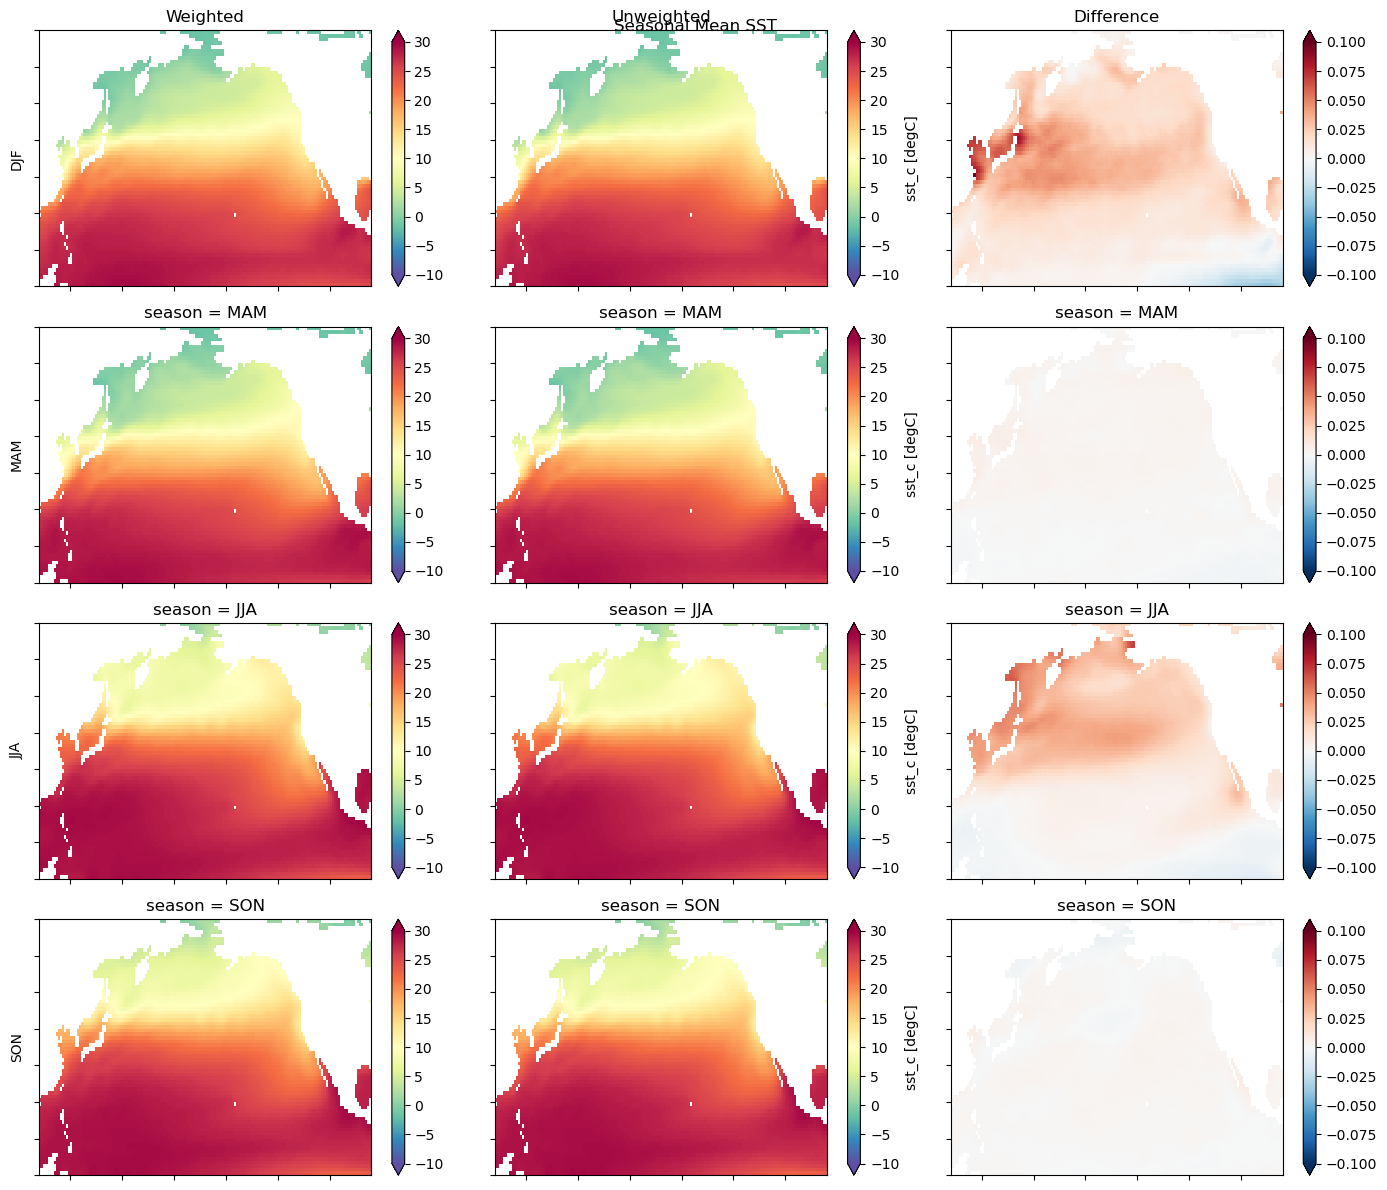

In [31]:
notnull = pd.notnull(sst_c_unweighted[0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))

for i, season in enumerate(("DJF","MAM","JJA","SON")):
    sst_c_weighted.sel(season=season).where(notnull).plot.pcolormesh(
        ax = axes[i,0],
        vmin = -10,
        vmax = 30,
        cmap = "Spectral_r",
        add_colorbar = True,
        extend = "both",
    )
    sst_c_unweighted.sel(season=season).where(notnull).plot.pcolormesh(
        ax = axes[i,1],
        vmin = -10,
        vmax = 30,
        cmap = "Spectral_r",
        add_colorbar = True,
        extend = "both",
    )
    sst_c_diff.sel(season=season).where(notnull).plot.pcolormesh(
        ax = axes[i,2],
        vmin = -0.1,
        vmax = 0.1,
        cmap = "RdBu_r",
        add_colorbar = True,
        extend = "both",
    )

    axes[i,0].set_ylabel(season)
    axes[i,1].set_ylabel("")
    axes[i,2].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

axes[0,0].set_title("Weighted")
axes[0,1].set_title("Unweighted")
axes[0,2].set_title("Difference")

plt.tight_layout()
fig.suptitle("Seasonal Mean SST")

## Nino3.4指標

Nino3.4領域のデータの選択は、次のいずれの方法でもよい。

In [32]:
sst_nino34_op1 = ds.sst.sel(lat=slice(5,-5), lon=slice(190,240))
sst_nino34_op1

<xarray.DataArray 'sst' (time: 1452, lat: 10, lon: 50)> Size: 3MB
[726000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
  * lon      (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
  * lat      (lat) float64 80B 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

In [33]:
sst_nino34_op2 = ds.sst.where((ds.sst.lat<5)
                              & (ds.sst.lat>-5)
                              & (ds.sst.lon>190)
                              & (ds.sst.lon<240)
                              , drop=True,)
sst_nino34_op2

<xarray.DataArray 'sst' (time: 1452, lat: 10, lon: 50)> Size: 3MB
array([[[301.15, 301.15, 301.15, ..., 300.35, 300.35, 300.35],
        [301.15, 301.15, 301.15, ..., 300.05, 300.05, 300.05],
        [301.25, 301.25, 301.25, ..., 299.65, 299.65, 299.65],
        ...,
        [301.75, 301.75, 301.75, ..., 299.35, 299.25, 299.15],
        [301.85, 301.75, 301.75, ..., 299.45, 299.45, 299.35],
        [301.85, 301.85, 301.75, ..., 299.65, 299.55, 299.45]],

       [[301.35, 301.35, 301.35, ..., 300.65, 300.65, 300.65],
        [301.55, 301.55, 301.45, ..., 300.45, 300.55, 300.55],
        [301.75, 301.75, 301.65, ..., 300.35, 300.35, 300.45],
        ...,
        [302.25, 302.15, 302.15, ..., 300.35, 300.25, 300.15],
        [302.15, 302.15, 302.05, ..., 300.35, 300.25, 300.15],
        [302.15, 302.15, 302.05, ..., 300.35, 300.25, 300.15]],

       [[301.15, 301.15, 301.15, ..., 300.85, 300.85, 300.85],
        [301.25, 301.15, 301.15, ..., 300.75, 300.75, 300.85],
        [301.25, 301.25, 301.25, ..., 300.55, 300.55, 300.65],
        ...,
...
        [300.65, 300.65, 300.45, ..., 296.15, 296.15, 295.95],
        [301.05, 301.05, 300.95, ..., 296.75, 296.65, 296.55],
        [301.35, 301.25, 301.25, ..., 297.25, 297.15, 296.95]],

       [[301.45, 301.45, 301.45, ..., 298.85, 298.85, 298.85],
        [301.15, 301.15, 301.05, ..., 298.05, 298.05, 298.15],
        [300.85, 300.75, 300.65, ..., 297.25, 297.25, 297.25],
        ...,
        [300.85, 300.85, 300.85, ..., 296.05, 295.95, 295.85],
        [301.25, 301.15, 301.15, ..., 296.55, 296.45, 296.35],
        [301.45, 301.45, 301.35, ..., 296.95, 296.85, 296.75]],

       [[300.95, 300.95, 300.95, ..., 299.35, 299.25, 299.25],
        [300.55, 300.55, 300.45, ..., 298.55, 298.55, 298.55],
        [300.25, 300.15, 300.05, ..., 297.75, 297.75, 297.75],
        ...,
        [300.35, 300.35, 300.35, ..., 296.75, 296.65, 296.65],
        [300.65, 300.65, 300.65, ..., 297.25, 297.15, 297.05],
        [300.95, 300.95, 300.85, ..., 297.45, 297.45, 297.35]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
  * lon      (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
  * lat      (lat) float64 80B 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

選択したnino34領域のSSTの気候値を``groupby()``を用いて作成する。

In [34]:
nino34_clim = (sst_nino34_op2
               .sel(time=slice("1991-01-01","2020-12-31"))
               .groupby("time.month")
               .mean())
nino34_clim

<xarray.DataArray 'sst' (month: 12, lat: 10, lon: 50)> Size: 24kB
array([[[301.33   , 301.28665, 301.2233 , ..., 299.68997, 299.70663,
         299.71002],
        [301.18332, 301.12003, 301.01666, ..., 299.30667, 299.3233 ,
         299.32663],
        [301.03006, 300.94666, 300.85663, ..., 298.8667 , 298.89   ,
         298.91666],
        ...,
        [301.37006, 301.30667, 301.22   , ..., 298.22665, 298.18332,
         298.11   ],
        [301.6667 , 301.58997, 301.52997, ..., 298.59   , 298.52664,
         298.43665],
        [301.92337, 301.87   , 301.81335, ..., 298.8134 , 298.7367 ,
         298.6633 ]],

       [[301.22665, 301.17   , 301.09332, ..., 300.00995, 300.02332,
         300.0466 ],
        [301.06668, 301.01007, 300.9    , ..., 299.75995, 299.75995,
         299.81998],
        [300.89337, 300.7833 , 300.67667, ..., 299.46664, 299.48666,
         299.5667 ],
...
        [301.8033 , 301.7833 , 301.7433 , ..., 297.86334, 297.7967 ,
         297.70996],
        [302.0667 , 302.01004, 301.96335, ..., 298.30328, 298.21338,
         298.1    ],
        [302.25   , 302.18668, 302.13   , ..., 298.55   , 298.44666,
         298.3366 ]],

       [[301.57333, 301.56   , 301.52997, ..., 299.7367 , 299.66663,
         299.65332],
        [301.39996, 301.35336, 301.29666, ..., 299.22662, 299.1767 ,
         299.1467 ],
        [301.2067 , 301.14337, 301.05667, ..., 298.61667, 298.55997,
         298.52   ],
        ...,
        [301.4933 , 301.4566 , 301.40997, ..., 297.93665, 297.86667,
         297.7934 ],
        [301.80002, 301.75003, 301.68332, ..., 298.36334, 298.27667,
         298.18665],
        [302.06   , 302.0133 , 301.96   , ..., 298.62003, 298.5267 ,
         298.42996]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
  * lat      (lat) float64 80B 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

nino34領域のSSTの偏差を作成する。

In [35]:
nino34_anom = sst_nino34_op2.groupby("time.month") - nino34_clim

面積の重みをつけた重み付き平均値を作成する。
ここで面積のかわりに格子点の緯度のコサインを取って重みとする。

In [36]:
weights = np.cos(np.deg2rad(sst_nino34_op2.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 10)> Size: 80B
array([0.99691733, 0.9981348 , 0.99904822, 0.99965732, 0.99996192,
       0.99996192, 0.99965732, 0.99904822, 0.9981348 , 0.99691733])
Coordinates:
  * lat      (lat) float64 80B 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [37]:
nino34 = nino34_anom.weighted(weights).mean(('lon','lat'), skipna=True)
nino34

<xarray.DataArray 'sst' (time: 1452)> Size: 12kB
array([ 0.74020639,  1.11950612,  0.56863096, ..., -1.32004657,
       -1.33872956, -1.33337765])
Coordinates:
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2020-12-01
    month    (time) int64 12kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

nino3.4指標の時系列を見てみる。

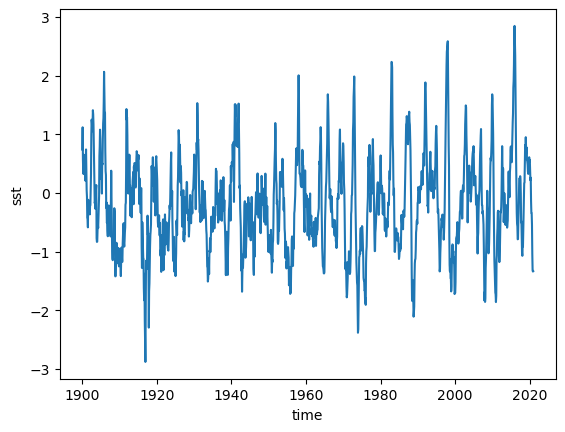

In [38]:
nino34.plot()

nino3.4指標に5ヶ月移動平均をかける。

In [39]:
nino34_smth5 = nino34.rolling(time=5, center=True).mean()

nino34指標の偏差と移動平均をかけたデータの時系列を描く。

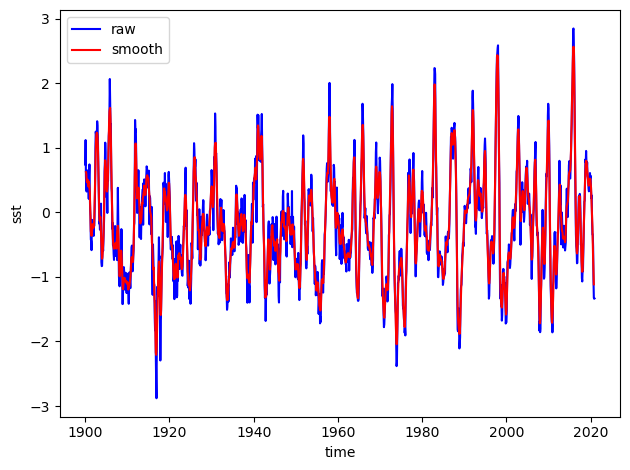

In [40]:
fig, ax = plt.subplots()

nino34.plot(ax=ax, color="blue", label="raw")
nino34_smth5.plot(ax=ax, color="red", label="smooth")
ax.legend(loc=0)
fig.tight_layout()

５か月移動平均をかけたnino34指標で0.5を超えた時期は赤色、-0.5を下回った時期は青色で着色する。

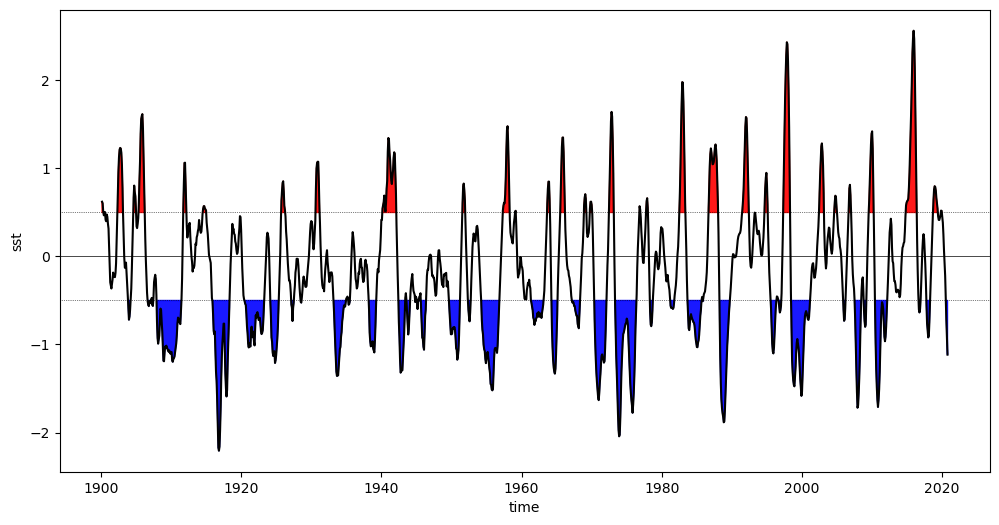

In [41]:
fig = plt.figure(figsize=(12,6))

plt.fill_between(
    nino34_smth5.time.data,
    nino34_smth5.where(nino34_smth5 >= 0.5).data,
    0.5,
    color="red",
    alpha=0.9,
)
plt.fill_between(
    nino34_smth5.time.data,
    nino34_smth5.where(nino34_smth5 <= -0.5).data,
    -0.5,
    color="blue",
    alpha=0.9,
)

nino34_smth5.plot(color="black")

plt.axhline(0, color="black", lw=0.5)
plt.axhline(
    0.5, color="black", linewidth=0.5, linestyle="dotted"
)
plt.axhline(
    -0.5, color="black", linewidth=0.5, linestyle="dotted"
)

５月移動平均をかけたnino34指標が、
0.5を上回った月には"nino"、0.5を下回った月には"nina"
という情報を付加する（boolean）。
なお、nino34_smth5と同じ形状(shape)のxarray.DataArrayを
作成するために、``xarray.full_like()``を用いる。

In [42]:
ninoYN = xr.full_like(nino34_smth5, "none", dtype="U4")
ninoYN[nino34_smth5 >= 0.5] = "nino"
ninoYN[nino34_smth5 <= -0.5] = "nina"

"nino"/"nina"の合成図（コンポジット）を作成する。

In [43]:
sst_nino_composite = (sst_anom
                      .groupby(ninoYN.rename("nino34_smth5"))
                      .mean(dim="time"))

El Nino年の合成図を描く。

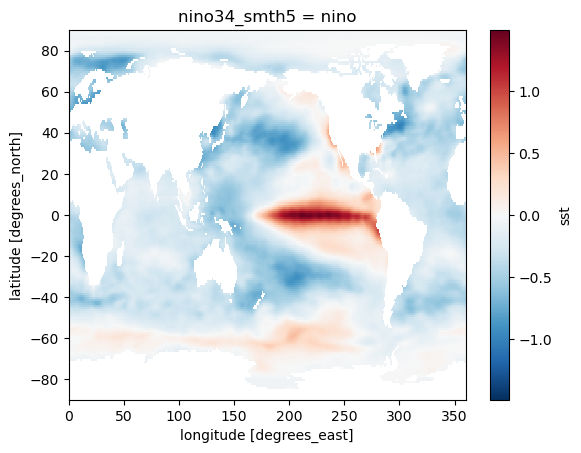

In [44]:
sst_nino_composite.sel(nino34_smth5="nino").plot()

La Nina年の合成図を描く。

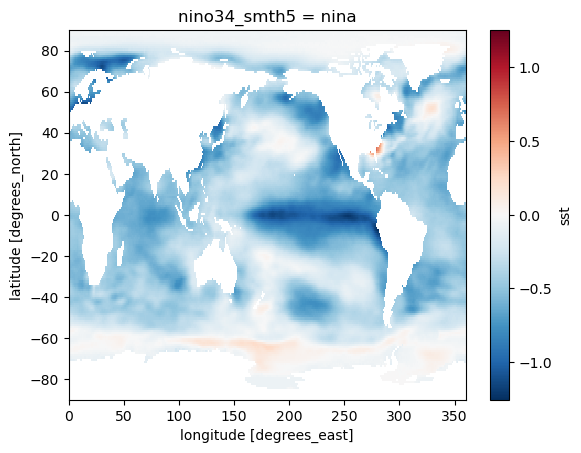

In [45]:
sst_nino_composite.sel(nino34_smth5="nina").plot()

## 緯度の向きの変更

緯度が北極から南極方向に定義されているDatasetの緯度の向きを変える方法。

In [46]:
sst_org = ds["sst"].isel(time=-1)
sst_org

<xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

In [47]:
sst_rev = sst_org.reindex(lat=list(reversed(sst_org["lat"])))
sst_rev

<xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    time     datetime64[ns] 8B 2020-12-01
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

## 経度の定義の変更

経度が 0度から360度で定義されているデータを、-180度から180度で定義し直す。
eScience Tools in Climate Scienceの[Some tips with xarray and pandas](https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/some-xarray-pandas-presentation_Sara.html)で紹介されている手法を利用する。

In [48]:
def convert360_180(_ds):
    attrs = _ds["lon"].attrs
    if _ds["lon"].min() >= 0:
        with xr.set_options(keep_attrs=True):
            _ds.coords["lon"] = (_ds["lon"] + 180) % 360 - 180
        _ds = _ds.sortby("lon")
    return _ds

In [49]:
sst_org["lon"]

<xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [50]:
sst_flip = convert360_180(sst_org)
sst_flip["lon"]

<xarray.DataArray 'lon' (lon: 360)> Size: 3kB
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

## isel の使い方

``isel()``を使ってデータを選択する。
まずデータの形状を"shape"で確認する。

In [51]:
sst_flip.shape

(180, 360)

以下の３行を実行するといずれも同じ結果が得られる。

In [52]:
sst_flip[0:10,0:10]

<xarray.DataArray 'sst' (lat: 10, lon: 10)> Size: 400B
[100 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lat      (lat) float64 80B 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 81.5 80.5
  * lon      (lon) float64 80B -179.5 -178.5 -177.5 ... -172.5 -171.5 -170.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

In [53]:
sst_flip.isel(lat=slice(0,10),lon=slice(0,10))

<xarray.DataArray 'sst' (lat: 10, lon: 10)> Size: 400B
[100 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lat      (lat) float64 80B 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 81.5 80.5
  * lon      (lon) float64 80B -179.5 -178.5 -177.5 ... -172.5 -171.5 -170.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

In [54]:
sst_flip.sel(lat=slice(90,80), lon=slice(-180,-170))

<xarray.DataArray 'sst' (lat: 10, lon: 10)> Size: 400B
[100 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-12-01
  * lat      (lat) float64 80B 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 81.5 80.5
  * lon      (lon) float64 80B -179.5 -178.5 -177.5 ... -172.5 -171.5 -170.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sea surface temperature
    units:          K

## 複数ファイルの読み込み

xarray.open_mfdataset()を用いる。ファイル名のリストを作成し、open_mfdataset()に与える。

In [55]:
files = []
for m in range(1,13):
    mo = "%02d" %(m)
    ff = "./Data/cobe2_sst.2010"+mo+".nc"
    files.append(ff)

files

['./Data/cobe2_sst.201001.nc',
 './Data/cobe2_sst.201002.nc',
 './Data/cobe2_sst.201003.nc',
 './Data/cobe2_sst.201004.nc',
 './Data/cobe2_sst.201005.nc',
 './Data/cobe2_sst.201006.nc',
 './Data/cobe2_sst.201007.nc',
 './Data/cobe2_sst.201008.nc',
 './Data/cobe2_sst.201009.nc',
 './Data/cobe2_sst.201010.nc',
 './Data/cobe2_sst.201011.nc',
 './Data/cobe2_sst.201012.nc']

In [56]:
ds3 = xr.open_mfdataset(files)
ds3

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 96B 2010-01-01 2010-02-01 ... 2010-12-01
  * lat      (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 3MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    title:           JMA COBE2 SST
    URL:             https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product...
    Convensions:     CF-1.4
    ConversionDate:  2023-09-22 16:25:24